In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from skimage import io
from torch.utils.data import Dataset,DataLoader
import os
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.metrics import classification_report

In [2]:
data = r'A:\two class data\2class'
meta = r'A:\two class data\met2.csv'

In [3]:
class Custom(Dataset):
    def __init__(self, data_dir, transform):      
    
        # path to images
        path2data=os.path.join(data_dir)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(meta)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("ID", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = io.imread(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [4]:
data_transformer = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(256),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.RandomRotation(degrees=(0, 180))])
dataset = Custom(data,data_transformer)

In [5]:
len_histo = len(dataset)
len_train = int(0.8*len_histo)                 #length of training data = 80% of total data
len_val = len_histo-len_train

TrainTest_ds,Val_ds=random_split(dataset,[len_train,len_val])      #spilt the data


print("validation dataset length:", len(Val_ds))




length = len(TrainTest_ds)
len_train = int(0.9*length)
len_test = length-len_train

Train_ds,Test_ds = random_split(TrainTest_ds,[len_train,len_test])

print('Train dataset length: ',len(Train_ds))
print('Test dataset length: ',len(Test_ds))

validation dataset length: 1447
Train dataset length:  5206
Test dataset length:  579


In [6]:
train_dl = DataLoader(Train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(Val_ds, batch_size=64, shuffle=True)  
test_dl = DataLoader(Test_ds,batch_size=64, shuffle=False)

In [7]:
for batch,(x,y) in enumerate(val_dl):
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 1, 256, 256])
torch.Size([64])


In [8]:
class CovNet(nn.Module):
    def __init__(self,num_classes):
        super(CovNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=6,stride=2), 
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),  
            nn.Conv2d(64,256,kernel_size=6,stride=2),   
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,1024,kernel_size=3,stride=2),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.avg = nn.AdaptiveAvgPool2d((5,5))
        self.cls = nn.Sequential(
            nn.Linear(1024*3*3,1000),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,1000),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,num_classes)
        )
        
    def forward(self,x):
        x = self.features(x)
        #x = self.avg(x)
        x = torch.flatten(x,1)
        x = self.cls(x)
        
        return F.log_softmax(x,dim=1)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
CNN = CovNet(2)
CNN.to(device)
optiM = optim.Adam(CNN.parameters(),lr=0.0001)

In [ ]:
CNN

In [11]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [12]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

In [13]:
def train(model,train_loader,validation_loader,loss_fn,optimizer,n_epochs,device):
    model = model.to(device)
    for epoch in range(n_epochs):
        training_loss = 0
        train_corr = 0
        totals = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input ,target = batch
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()*target.size(0)
            totals += target.size(0)
            predicted = torch.argmax(output,1)
            train_corr += (predicted == target).sum().item()



        validation_loss = 0
        val_corr = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                input ,target = batch
                input = input.to(device)
                target = target.to(device)
                output = model(input)
                loss = loss_fn(output,target)
                total += target.size(0)
                validation_loss += loss.item()*target.size(0)
                predicted = torch.argmax(output,1)
                val_corr += (predicted == target).sum().item()


        train_acc = train_corr/totals*100
        val_acc = val_corr/total*100
        training_loss = training_loss/totals
        validation_loss = validation_loss/total
        train_losses.append(training_loss)
        val_losses.append(validation_loss)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)


    
        print('Epoch : {}/{} ...Training Acc : {:.6f}     Training Loss : {:.6f}     Validation Acc : {:.6f}     Validation Loss : {:.6f}'.format(epoch+1,n_epochs,train_acc,training_loss,val_acc,validation_loss))





      

In [14]:
train(CNN,train_dl,val_dl,nn.NLLLoss(),optiM,100,device=device)

C:\Users\dhart\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch : 1/100 ...Training Acc : 59.316174     Training Loss : 0.666325     Validation Acc : 64.340014     Validation Loss : 0.629219
Epoch : 2/100 ...Training Acc : 66.999616     Training Loss : 0.611026     Validation Acc : 55.908777     Validation Loss : 0.741370
Epoch : 3/100 ...Training Acc : 70.860546     Training Loss : 0.562876     Validation Acc : 72.494817     Validation Loss : 0.546516
Epoch : 4/100 ...Training Acc : 71.494430     Training Loss : 0.555045     Validation Acc : 77.055978     Validation Loss : 0.517932
Epoch : 5/100 ...Training Acc : 75.605071     Training Loss : 0.503890     Validation Acc : 78.921907     Validation Loss : 0.467528
Epoch : 6/100 ...Training Acc : 78.025355     Training Loss : 0.460309     Validation Acc : 79.336558     Validation Loss : 0.467913
Epoch : 7/100 ...Training Acc : 78.812908     Training Loss : 0.448734     Validation Acc : 80.856945     Validation Loss : 0.429459
Epoch : 8/100 ...Training Acc : 80.215136     Training Loss : 0.42693

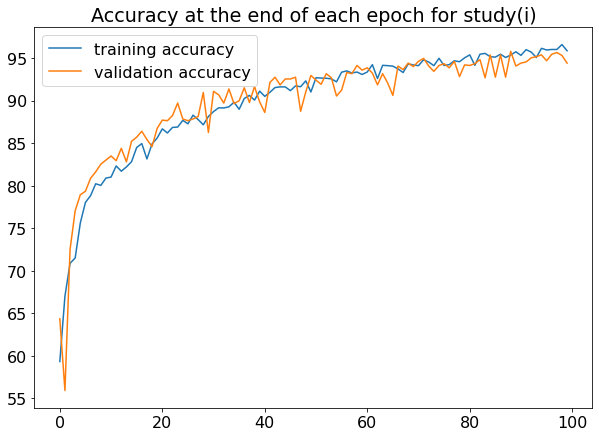

In [18]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.title('Accuracy at the end of each epoch for study(i)')
plt.legend();

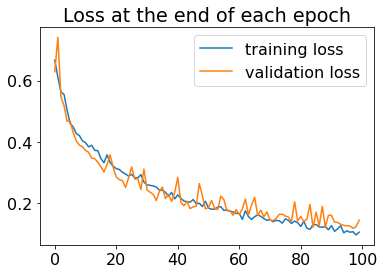

In [19]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [20]:
test_losses = []
test_accuracy = []

In [21]:
def test(model,test_loader,loss_fn,n_epochs,device=device):
    test_loss = 0
    test_corr = 0
    totals = 0
    y_pred = []
    y_true = []
    model.eval()
    for epoch in range(n_epochs):
        with torch.no_grad():
            for data in test_loader:
                input ,target = data
                input = input.to(device)
                target = target.to(device)
                output = model(input)
                loss = loss_fn(output,target)
                test_loss += loss.item()*target.size(0)
                totals += target.size(0)
                predicted = torch.argmax(output,1)
                test_corr = (predicted==target).sum().item()
                y_true.append(target)
                y_pred.append(predicted)

        test_loss = test_loss/totals
        test_acc = test_corr/totals*100
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print('----------------------------------------------------------------------------')
        print('Y_true:{}'.format(y_true))
        print('----------------------------------------------------------------------------')
        print('Y_pred:{}'.format(y_pred))

    

In [22]:
test(CNN,test_dl,nn.NLLLoss(),1,device=device)

----------------------------------------------------------------------------
Y_true:[tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0'), tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0'), tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0'), tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

In [23]:
y_true = [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,1, 1, 0]

In [24]:
y_pred = [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,1, 1, 0]

In [25]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
print('Accuracy : {}'.format(accuracy_score(y_true,y_pred)*100))
print('F1 Score : {}'.format(f1_score(y_true,y_pred)*100))
print('Sensitivity : {}'.format(recall_score(y_true,y_pred)*100))
print('Precision : {}'.format(precision_score(y_true,y_pred)*100))

Accuracy : 94.47322970639033
F1 Score : 94.55782312925169
Sensitivity : 94.23728813559322
Precision : 94.88054607508532


## 00:57-3:09